# Load data

In [29]:
from xgboost import XGBRegressor

import data_prep
from EDA import multicolin

df_master = data_prep.prep_data('C:\\Users\\HP\\Downloads\\FiinProX_DE_Doanh_nghiep_20250721.xlsx')
print(df_master.head())

vars_mini company platform  year        ebitda       revenue          cogs  \
0             NaN      NaN  2015           NaN           NaN           NaN   
1             NaN      NaN  2016           NaN           NaN           NaN   
2             NaN      NaN  2017           NaN           NaN           NaN   
3             NaN      NaN  2018           NaN           NaN           NaN   
4             NaN      NaN  2019  2.616088e+12  3.702945e+12 -1.006181e+12   

vars_mini  sales_cost    admin_cost  net_op_profit  short_receive  ...  \
0                 NaN           NaN            NaN            NaN  ...   
1                 NaN           NaN            NaN            NaN  ...   
2                 NaN           NaN            NaN            NaN  ...   
3                 NaN           NaN            NaN            NaN  ...   
4                 0.0 -8.067600e+10   3.090044e+11   1.772164e+12  ...   

vars_mini          cash   fixed_asset  other_long_asset          cwip  \
0            

# Preprocess raw data

### Main data

In [30]:
# Check for duplicate (no duplication)
df_master.duplicated().sum()

np.int64(0)

In [31]:
# Drop null 'company' (due to small number)
df_master.dropna(subset=['company'], inplace=True)

In [32]:
import pandas as pd
# Data 1: Imbalanced data drop for and gov
df_imbalanced = df_master.copy()
df_imbal_noown = df_imbalanced.drop(columns=['for_own', 'gov_own'])
df_imbal_noown.dropna(inplace=True)
df_imbal_noown.shape

(18700, 23)

Comment:
- Many columns have weird values:
    + revenue has negative values
    + expenditure has negative values
- This, however, is not recording error but rather due to intention. For example, customers require refund for products pruchased in the previous accounting period -> be accounted as sales return in this period -> negative revenue
- On the other hand, reeceiving refund from seller would result in negative cost.

### Backup data (opt)

In [33]:
# Data 2 (backup): Imbalanced full col
df_imbal_dropall = df_imbalanced.dropna()
df_imbal_dropall.shape

(8073, 25)

In [34]:
# Data 3 (backup): Balanced (no gov and for own)
df_balanced_noown = df_master.copy()
df_balanced_noown.drop(columns=['for_own', 'gov_own'], inplace=True)


'''
    Drop all nulls
'''
result_dropallnull = []
for idx, group in df_balanced_noown.groupby('company'):
    if group.isna().sum().sum()>0:
        continue
    else:
        result_dropallnull.append(group)

df_bal_nonull = pd.concat(result_dropallnull, ignore_index=True)
print(df_bal_nonull.shape)

(12730, 23)


In [35]:
# Data 4: balanced full col
df_balanced_full = df_master.copy()

'''
    Drop all nulls
    Return nothing == all companies have some null when for and gov own exist
'''


'\n    Drop all nulls\n    Return nothing == all companies have some null when for and gov own exist\n'

# EDA

In [36]:
# Data 1: (imbalance, no onwership)
import EDA
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: xlabel='year', ylabel='ebitda'>

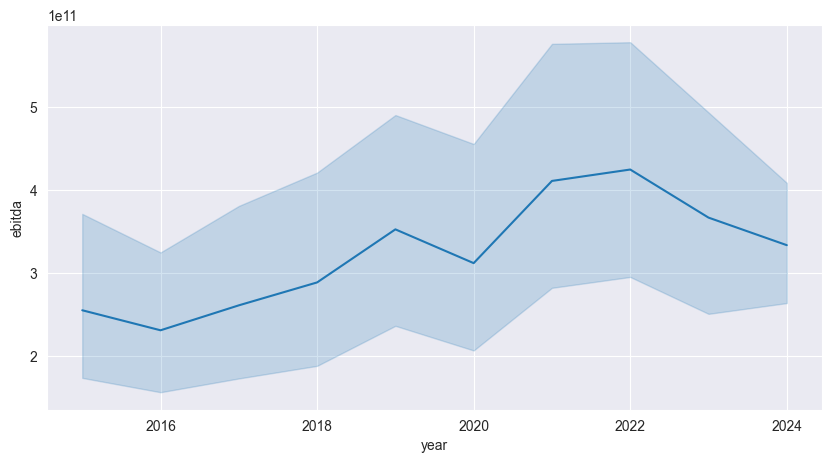

In [37]:
# EDA
'''
    General trend of EBITDA over the year
'''
plt.figure(figsize=(10,5))
sns.lineplot(data=df_imbal_noown, x='year', y='ebitda')

Comment:
- Generally, ebitda went up slightly from 2015 to 2024
- However, the light shade around the line also reveals high variance in ebitda of companies

In [38]:
'''
    Check for number of obs/quartile range
'''
for idx, group in df_imbal_noown.groupby('year'):
    a = EDA.quartile_table(group, 'ebitda')
    print(f'Year {idx}')
    print(a)

Year 2015
  Quartile range  Num obs
0             q1      490
1             q2      490
2             q3      490
3             q4      490
Year 2016
  Quartile range  Num obs
0             q1      550
1             q2      549
2             q3      549
3             q4      550
Year 2017
  Quartile range  Num obs
0             q1      558
1             q2      529
2             q3      543
3             q4      544
Year 2018
  Quartile range  Num obs
0             q1      541
1             q2      541
2             q3      541
3             q4      541
Year 2019
  Quartile range  Num obs
0             q1      450
1             q2      449
2             q3      449
3             q4      450
Year 2020
  Quartile range  Num obs
0             q1      440
1             q2      440
2             q3      440
3             q4      440
Year 2021
  Quartile range  Num obs
0             q1      430
1             q2      429
2             q3      429
3             q4      430
Year 2022
  Quartile

Comment:
- Distribution of ebitda value of companies are spread equally among quartile ranges, in all years
- This means data of ebitda has high variance among companies in every year

In [39]:
'''
    Correlation with target variable
'''
df_imbal_noown.drop(columns=['company', 'platform']).corr()['ebitda']

vars_mini
year                 0.019289
ebitda               1.000000
revenue              0.749819
cogs                -0.807773
sales_cost          -0.491252
admin_cost          -0.764722
net_op_profit        0.647062
short_receive        0.551980
in_stock             0.403575
invest_nav           0.174400
long_receive         0.423612
long_liability       0.871524
short_liability      0.678473
cash                 0.787239
fixed_asset          0.892432
other_long_asset     0.507494
cwip                 0.694640
other_short_asset    0.517662
long_invest          0.492669
equity_fund          0.789879
other_fund           0.020470
Name: ebitda, dtype: float64

Comment:
- cogs and admin_cost strongly correlate negatively with ebitda
- fixed asset, long-liability, equity_fund, and cash are mostly positively correlated with ebitda

In [40]:
# Check for statistical issue (if any)

Multicolinearity:
- Variable with issue (4 most serious ones):
    + fixed asset
    + long_lia
    + short_lia
    + equity_fund
- Consequence: reduce explainability of feature variables on target variables

In [41]:
EDA.multicolin(df_imbal_noown)

,features,VIF
0,year,0.000002
1,ebitda,25.130055
2,revenue,6.208081
3,cogs,8.247907
4,sales_cost,2.640032
5,admin_cost,6.039716
6,net_op_profit,10.831798
7,short_receive,17.714173
8,in_stock,4.309120
9,invest_nav,2.254587


Heteeokedasticity:
- low p-value indicates presence of hetereokedasticity
- Consequences:
    + reduce accuracy in linear models

In [42]:
EDA.hetereo(df = df_imbal_noown,
            endog = 'ebitda',
            num_drop = 'year')

[('Lagrange multiplier statistic', np.float64(2723.026409715606)),
 ('p-value', np.float64(0.0)),
 ('f-value', np.float64(167.56395678821184)),
 ('f p-value', np.float64(0.0))]

Comment:
- Since I focus on predicting the outcomes rather than intepreting feature importance, we can safely ignore multicolinearity
- Hetereokedasticity, however, will be accounted for if the used model utilize linear regression.

# Cross validation for optimal model

## Original

In [43]:
# Data 1
import train_test_pipeline as ttp
from modelCV_exe import Execution as exe

- Task: Predict ebitda of companies in the list (forecasting problem)
- Algorithm and Model choice (for the scope of this project, I'll limit my choice to most popular models and algorithms for forecasting problem):
    - Support Vector Regression (SVR):
        + Nonparametric: The algorithm does not assume the distribution of data. (Arnout Van Messem, 2019, https://doi.org/10.1016/bs.host.2019.08.003)
        + Robust to outliers: at its core, SVR works only with "hardest-to-be-classified" data points, not caring about the whole dataset. Since, I did not treat outliers in EDA, this characteristic of SVR proves useful. (A.V.Messem, 2019)
        + More, the algorithm can implicitly transform the data into linear problem (add dimensions) to self-improve without explicit programming. (A.V.Messem, 2019)

    - XGBoost:

        + Nonparametric
        + Support regularization, significantly reduce the need for feature engineering (though it cannot account for cases for adding features with more explanation power, it can account for cases where features are redundant) -> beneficial when domain knowledge is limited
        + Have been used in many panel data science researches (Shenlong Huang and Lingyun Hu, 2024; Reza Sotudeh et al., 2025; Jonathan Fuhr and Dominik Papies, 2024)

    - Random Forest:

        + Nonparametric
        + Random forest train data on multiple subsets of data, each using distinct subset of features, reducing overfitting as a result
        + However, normal RF model often assume independence among observations, violating panel data's structure. (Jianchang Hu and Silke Szymczak, 2023, https://doi.org/10.1093/bib/bbad002)


In [44]:
# Hold out set + input set + train + val sets
    # drop platform col
df_imbal_noown_inuse = df_imbal_noown.drop(columns=['platform'])

    # setup data
create_data = ttp.TrainTestPipe(data = df_imbal_noown_inuse)

df_input, df_holdout, X_train, X_val, y_train, y_val = create_data.holdout_and_split(
    panel_col = ['company', 'year'],
    level = 1
)

    # Last check of data
df_input.shape, df_holdout.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape

((17127, 20), (1573, 20), (13772, 19), (3355, 19), (13772,), (3355,))

- Train_test_split follow instruction from (Augusto Cerqua et al., 2025 - https://ssrn.com/abstract=5014594).
- The article instructed, for the problem of forecasting (forecast ebitda of companies in the future rather than predict out-of-sample entity), non-random split by time can be beneficial though at the expense of cross-sectional data leakage
- However, since the main purpose is to forecast future value of existing companies, cross-sectional leakage might not be concerning issue (Augusto et al., 2025)

Note:
- Since different algorithms + hyper-params yield quite close scores, from now on, only XGBoost will be tested until satisfactory RMSE and MAPE are found (this aims to save computational capacity as XGBoost runs fast)

In [45]:
# Cros-validation for best algorithm + hyper-parameter tuning
cross_val = ttp.TrainTestPipe(data = df_imbal_noown_inuse)
cross_val.hyper_parameter_tuning(n_splits=3, test_size=2)

Processing XGBoost: ...


,algo_used,params,mean_test_r2,mean_test_mape,mean_test_rmse
13,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.845284,5.001238e+24,1.106833e+12
14,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.844803,4.789280e+24,1.105208e+12
11,XGBoost,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.842149,8.648460e+24,1.119312e+12
16,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.838585,4.285617e+24,1.127338e+12
17,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.837516,4.221602e+24,1.127934e+12
12,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.836970,5.985376e+24,1.145643e+12
10,XGBoost,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.836879,8.498268e+24,1.144178e+12
15,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.832318,4.874151e+24,1.160917e+12
33,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.824002,6.416685e+24,1.172940e+12
35,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.823980,6.325833e+24,1.172786e+12


Comment on run test (due to computational expense, only some hyper-params are tested):
- Generally, R-squared of model is high, signifying model fits better line than simply guessing mean value
- Despite that, RMSE and MAPE is still very high (the value of which is near predicted value (at 10^27)), signifying that predicted values are still very variant and not reliable.
- Additional methods would be tried to improve this

## Balanced data

What I'll do:
- Change data structure to see if scores improve

In [46]:
# Cross-val for data 3
crossval = exe(data=df_bal_nonull)
crossval.execute(n_splits=4, test_size=2)

Processing XGBoost: ...


,algo_used,params,mean_test_r2,mean_test_mape,mean_test_rmse
12,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.852272,1.229508e+24,5.751677e+11
13,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.851737,1.198497e+24,5.843715e+11
15,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.851315,1.106692e+24,5.769376e+11
14,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.849906,1.173178e+24,5.894107e+11
16,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.847629,1.078864e+24,5.933994e+11
17,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.843776,1.081205e+24,6.023436e+11
33,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.838709,1.576861e+24,6.083409e+11
34,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.838628,1.573098e+24,6.084851e+11
35,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.838628,1.572907e+24,6.084865e+11
11,XGBoost,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.833930,1.250482e+24,6.199129e+11


Comment:
- Significant improvements are seen when data is balanced:
    + Improved R-squared for top 2 XGBoost
    + RMSE decreased by ~45%
    + MAPE decreased by ~78%
- However, RMSE and MAPE is still high

## Scaling + delete outlier

What I'll do:
- Detect abnormal EBITDA datapoints for deletion
- Scale EBITDA to decrease variance

Outlier treatment

In [47]:
# Outliers deletion IQR method
# Loss check
bf = df_imbal_noown_inuse
af = df_imbal_noown_inuse[
    (df_imbal_noown_inuse['ebitda']<=bf['ebitda'].quantile(.75))&
    (df_imbal_noown_inuse['ebitda']>=bf['ebitda'].quantile(.25))]
print(f'Before drop: {bf.shape[0]}')
print(f'After drop: {af.shape[0]}')
print(f'Loss: {bf.shape[0]-af.shape[0]}')

# Data without outlier
no_outlier = exe(data=af)
no_outlier.execute(n_splits=4, test_size=2)

Before drop: 18700
After drop: 9350
Loss: 9350
Processing XGBoost: ...



KeyboardInterrupt



Comment:
- MAPE improves significantly -> on average, predicted value is 40% off actual value
- RMSE also improved by >10 times.
- This came with a little decrease in R-squared and half the data dropped

Scale target variable (ebitda)

In [20]:
# Scale with sign log transformation

# Formula: sign(-/+)*log(|y|+1)
import numpy as np
df_ln = df_imbal_noown_inuse.copy()
df_ln['ebitda_trans'] = df_ln['ebitda'].apply(
    lambda x: np.sign(x)*np.log1p(abs(x)))
name_map = {
    'ebitda': 'ebitda_ori',
    'ebitda_trans': 'ebitda'
}
df_ln = df_ln.rename(columns=name_map)

scale_log = exe(data=df_ln.drop(columns='ebitda_ori'))
scale_log.execute(n_splits=4, test_size=2)

Processing XGBoost: ...


,algo_used,params,mean_test_r2,mean_test_mape,mean_test_rmse
17,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.669612,9.454582e+14,9.267242
16,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.668828,9.569671e+14,9.278158
13,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.668110,8.660641e+14,9.289596
15,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.667692,7.684761e+14,9.294451
14,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.667039,1.021333e+15,9.303615
12,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.665773,7.080012e+14,9.322963
8,XGBoost,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.664949,9.875691e+14,9.331561
26,XGBoost,"{'learning_rate': 0.01, 'max_depth': 10, 'n_es...",0.664949,9.875691e+14,9.331561
5,XGBoost,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.658632,9.900706e+14,9.421422
23,XGBoost,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",0.658632,9.900706e+14,9.421422


Comment:
- R-squared decreased compare to outlier-treated and original data
- However, MAPE decreased compared to original data (though way larger than outlier treated)
- This proves scaling with log does improve high variance issue

In [21]:
# Scale with yeo-johnson method

# Set up data
df_yeo = df_imbal_noown_inuse.copy()
spliter = ttp.TrainTestPipe(data=df_yeo)
df_yeo_input = spliter.holdout_and_split(panel_col=['company', 'year'], level=1)[0]

# cross validation with yeo-johnson transformed target var
from panelsplit.cross_validation import PanelSplit
from xgboost import XGBRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import root_mean_squared_error as rmse, mean_absolute_percentage_error as mape, r2_score as r2
import hyparam_testingmodel as hp
from itertools import product
from statistics import mean

periods = df_yeo_input.index.get_level_values(1)
panel_split = PanelSplit(periods = periods, n_splits = 4, test_size = 2)
all_splits = panel_split.split()


# param-mix
key, value = zip(*hp.param_xg.items())
for v in product(*value):
    params = dict(zip(key, v))

    rmse_sc = []
    mape_sc = []
    r2_sc = []

    # Iterate through each fold
    for tr_idx, val_idx in all_splits:
        X_tr, y_tr = df_yeo_input.drop(columns='ebitda').loc[tr_idx], df_yeo_input['ebitda'].loc[tr_idx]
        X_val, y_val = df_yeo_input.drop(columns='ebitda').loc[val_idx], df_yeo_input['ebitda'].loc[val_idx]

        # yeo-johnson transdormed
        yeo_trans = PowerTransformer(method = 'yeo-johnson', standardize = False) # do not change distribution (just skewness)
        y_tr_trans = yeo_trans.fit_transform(y_tr.values.reshape(-1,1))
        y_val_trans = yeo_trans.transform(y_val.values.reshape(-1,1))

        # Run model
        xgb_reg = XGBRegressor(**params)
        xgb_reg.fit(X_tr, y_tr_trans)
        y_pred = xgb_reg.predict(X_val)

        # Scoring
        root_mse_score = rmse(y_pred, y_val_trans)
        mean_ape_score = mape(y_pred, y_val_trans)
        r_squared_score = r2(y_pred, y_val_trans)

        rmse_sc.append(root_mse_score)
        mape_sc.append(mean_ape_score)
        r2_sc.append(r_squared_score)


    param_rmse = mean(rmse_sc)
    param_mape = mean(mape_sc)
    param_r2 = mean(r2_sc)

    print(f'Parameters: {params} with rmse: {param_rmse:,.2f}, mape: {param_mape:,.2f}, r2: {param_r2:,.2f}')


Parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.5} with rmse: 768,788,694,171.58, mape: 2.18, r2: -19.73
Parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.5} with rmse: 744,381,517,766.10, mape: 1.98, r2: -15.85
Parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.5} with rmse: 742,488,844,073.85, mape: 2.32, r2: -15.67
Parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 2, 'subsample': 0.5} with rmse: 726,505,815,191.76, mape: 2.05, r2: -3.94
Parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.5} with rmse: 698,661,833,957.31, mape: 2.57, r2: -3.34
Parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.5} with rmse: 698,590,853,854.02, mape: 2.47, r2: -3.44
Parameters: {'n_estimators': 100, 'learning_rate': 0.01, 'max_depth': 2, 'subsample': 0.5} with rmse: 768,788,694,171.58, mape: 2.1

Comment:
- yeo-johnson proves ineffective, making prediction worse

## Feature engineer

What I'll do:
- Add lag features to capture temporal factor in the data
- Risk: many companies only have 1 - 2 years of data -> data loss when lagged
- Lag vars:
    + test with lagged ebitda
    + test with lagged features which have high correlation with ebitda

In [22]:
import create_lag
# used data
df_lag_imbal = df_imbal_noown_inuse.copy()

# features and var list
# target var
var_tar = ['ebitda']

# correlation > 50
vars_high_corr = ['fixed_asset', 'long_liability', 'equity_fund', 'cash', 'revenue', 'cwip', 'short_liability', 'net_op_profit', 'short_receive', 'other_short_asset', 'other_long_asset', 'long_invest', 'admin_cost', 'cogs']

# correlation < 50
vars_low_corr = ['long_receive', 'in_stock', 'sales_cost']

# all features and target
vars_all = ['ebitda', 'fixed_asset', 'long_liability', 'equity_fund', 'cash', 'revenue', 'cwip', 'short_liability', 'net_op_profit', 'short_receive', 'other_short_asset', 'other_long_asset', 'long_invest', 'long_receive', 'in_stock', 'sales_cost', 'admin_cost', 'cogs']

In [23]:
# test all lags
df_lagged = create_lag.create_lag(df = df_imbal_noown_inuse,
                                        id_col = 'company',
                                        time_col = 'year',
                                        cols = var_tar,
                                        lag_num = 3)
df_lagged.shape

(11370, 25)

In [24]:
cros_val_lag = exe(data=df_lagged)
cros_val_lag.execute(n_splits=3, test_size = 1)

Processing XGBoost: ...


,algo_used,params,mean_test_r2,mean_test_mape,mean_test_rmse
14,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.881694,2.366655e+24,1.008014e+12
17,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.881476,3.225765e+24,1.005815e+12
16,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.879963,3.153131e+24,1.010209e+12
13,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.879217,2.487322e+24,1.016867e+12
11,XGBoost,"{'learning_rate': 0.05, 'max_depth': 2, 'n_est...",0.873946,3.344764e+24,1.039894e+12
15,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.873289,1.451523e+24,1.038209e+12
12,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.872154,1.335080e+24,1.045813e+12
35,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.871328,5.912055e+24,1.043748e+12
34,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.871314,5.913710e+24,1.043802e+12
33,XGBoost,"{'learning_rate': 0.3, 'max_depth': 10, 'n_est...",0.870650,5.967052e+24,1.046298e+12


Comment:
- R-squared improved with lagged var
- MAPE also improved by at least 2 times
- RMSE, however, does not improve

# Final model

Final model used data:
- balanced (companies having the same years recorded)
- Then, dropping all outliers (may make the data unbalanced again)
- Lag ebitda (target var) by three years

In [25]:
# outlier drop (scale) + balance
df_bal_lag_logscale = df_bal_nonull[
    (df_bal_nonull['ebitda']<=df_bal_nonull['ebitda'].quantile(.75))&
    (df_bal_nonull['ebitda']>=df_bal_nonull['ebitda'].quantile(.25))]

df_bal_outlier_lag = df_bal_lag_logscale.copy()

# lag
var_tar_2 = ['ebitda']

df_bal_lag_logscale = create_lag.create_lag(
    df=df_bal_lag_logscale,
    id_col='company',
    time_col='year',
    cols=var_tar_2,
    lag_num=3
)


# cross_val
cros_val_bal_lag_scale = exe(data=df_bal_lag_logscale)
cros_val_bal_lag_scale.execute(n_splits=3, test_size = 1, test=False)

Processing Randome_forest: ...
Processing SVR: ...
Processing XGBoost: ...


,algo_used,params,mean_test_r2,mean_test_mape,mean_test_rmse
162,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.799615,0.275645,1.364858e+10
161,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.797950,0.280132,1.370560e+10
165,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.796160,0.282073,1.376367e+10
164,XGBoost,"{'learning_rate': 0.05, 'max_depth': 10, 'n_es...",0.795318,0.284405,1.379238e+10
160,XGBoost,"{'learning_rate': 0.05, 'max_depth': 6, 'n_est...",0.792076,0.296035,1.390668e+10
...,...,...,...,...,...
166,XGBoost,"{'learning_rate': 0.01, 'max_depth': 2, 'n_est...",0.570588,0.625389,1.999431e+10
147,SVR,"{'C': 5, 'kernel': 'poly'}",-0.083794,0.770996,3.176621e+10
145,SVR,"{'C': 1, 'kernel': 'poly'}",-0.083872,0.770999,3.176738e+10
146,SVR,"{'C': 5, 'kernel': 'rbf'}",-0.083892,0.771000,3.176767e+10


In [71]:
# Main model training

import create_lag
from sklearn.metrics import root_mean_squared_error as rmse, mean_absolute_percentage_error as mape, r2_score as r2
# Train_test
a = ttp.TrainTestPipe(data=df_bal_outlier_lag)
df_input_fin, df_hold_fin = a.holdout_and_split(panel_col=['company', 'year'],
                                                level=1)[0:2]

# Processing data for training purpose
df_input_fin.drop(columns='platform', inplace=True)
df_hold_fin.drop(columns='platform', inplace=True)
df_input_train = df_input_fin.reset_index()

df_input_lagbalout = create_lag.create_lag(
    df=df_input_train,
    id_col='company',
    time_col='year',
    cols=['ebitda'],
    lag_num=3
)

df_input_lagbalout.set_index(['company', 'year'], inplace=True)
# Train_test_split
idx_val = [2023,2022,2021]

X_train = df_input_lagbalout[~df_input_lagbalout.index.get_level_values(1).isin(idx_val)].drop(columns='ebitda')
y_train = df_input_lagbalout['ebitda'][~df_input_lagbalout.index.get_level_values(1).isin(idx_val)]
X_val = df_input_lagbalout[df_input_lagbalout.index.get_level_values(1).isin(idx_val)].drop(columns='ebitda')
y_val = df_input_lagbalout['ebitda'][df_input_lagbalout.index.get_level_values(1).isin(idx_val)]

# Train model
xgb_reg = XGBRegressor(
    learning_rate = 0.05,
    n_estimators = 100,
    max_depth=3,
    subsample=0.5
)

model = xgb_reg.fit(X_train, y_train)
y_train_pred = model.predict(X_train)

print('-'*20, 'Training Model_score', '-'*20)
print(f'RMSE: {rmse(y_train_pred, y_train):,.2f}')
print(f'MAPE: {mape(y_train_pred, y_train):.2f}')
print(f'R2: {r2(y_train_pred, y_train):.2f}')


y_pred = model.predict(X_val)

print('-'*20, 'Validating Model_score', '-'*20)
print(f'RMSE: {rmse(y_pred, y_val):,.2f}')
print(f'MAPE: {mape(y_pred, y_val):.2f}')
print(f'R2: {r2(y_pred, y_val):.2f}')


-------------------- Training Model_score --------------------
RMSE: 9,663,491,627.04
MAPE: 0.18
R2: 0.87
-------------------- Validating Model_score --------------------
RMSE: 14,585,114,168.59
MAPE: 0.24
R2: 0.70


Comment:
- CLoser inspection show that the chosen hyper-param cause overfitting
- Solution:
    + decrease n_estimators: 300 -> 100
    + decrease max_depth: 6 -> 3
- The result is shown as above

In [73]:
# Test on held-out set
# data creation (add lags)
lag_list = [2023, 2022, 2021]
# get index of company from df_hold_fin
u_company = df_hold_fin.index.get_level_values(0).unique()
df_fin_lag_3 = df_input_fin[(df_input_fin.index.get_level_values(0).isin(u_company))&
                            (df_input_fin.index.get_level_values(1).isin(lag_list))
]

# concat into df_hold_fin
df_hold_fin_new = pd.concat([df_hold_fin, df_fin_lag_3], axis=0)
abc = df_hold_fin_new.reset_index()
df_hold_out = create_lag.create_lag(
    df = abc,
    id_col = 'company',
    time_col = 'year',
    cols = ['ebitda'],
    lag_num = 3
)
df_hold_out.set_index(['company', 'year'], inplace=True)

# Predict + result
y_hold_pred = model.predict(df_hold_out.drop(columns='ebitda'))
y_val_h = df_hold_out['ebitda']
print('-'*20, ' Testing Model_score', '-'*20)
print(f'RMSE: {rmse(y_hold_pred, y_val_h):,.2f}')
print(f'MAPE: {mape(y_hold_pred, y_val_h):.2f}')
print(f'R2: {r2(y_hold_pred, y_val_h):.2f}')

--------------------  Testing Model_score --------------------
RMSE: 12,458,954,615.85
MAPE: 0.20
R2: 0.77


Comment:
- Metric on hold-out set is not too far from validation set (a little better)
- This proves model's consistency in prediction


## Limitation of the model
- Data input shortage: since the model returned best result when outliers are dropped based on IQR method, much outlier has been dropped in exchange for better prediction. However, this made the model less powerful in times of outlying or unexpected events that make ebitda abnormally high or low.
- MECE of algorithm: the model only used most commonly applied algorithm instead of trying all available algorithms, risking missing some good algorithms.